In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import fbeta_score, accuracy_score,precision_score, recall_score
#from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline


In [3]:
# Load data
df = pd.read_csv('HR_comma_sep.csv')

## Exploratory data-analysis

In [4]:
df.shape

(14999, 10)

In [5]:
df.head(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


In [6]:
# Tidying the dataset, correcting column names and changing column order for convenience
df.columns = ['satisfact_level', 'last_eval', 'number_projects', 'average_monthly_hours',
             'time_spent_company', 'work_accident', 'left', 'promotion_last_5years', 'dep', 'salary']
df = df[['satisfact_level', 'last_eval', 'number_projects', 'average_monthly_hours',
             'time_spent_company', 'work_accident', 'promotion_last_5years', 'dep', 'salary', 'left']]
df.head(3)

,satisfact_level,last_eval,number_projects,average_monthly_hours,time_spent_company,work_accident,promotion_last_5years,dep,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1


In [7]:
df.salary.value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfact_level          14999 non-null float64
last_eval                14999 non-null float64
number_projects          14999 non-null int64
average_monthly_hours    14999 non-null int64
time_spent_company       14999 non-null int64
work_accident            14999 non-null int64
promotion_last_5years    14999 non-null int64
dep                      14999 non-null object
salary                   14999 non-null object
left                     14999 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [9]:
df.isnull().sum()

satisfact_level          0
last_eval                0
number_projects          0
average_monthly_hours    0
time_spent_company       0
work_accident            0
promotion_last_5years    0
dep                      0
salary                   0
left                     0
dtype: int64

In [10]:
df.describe()

,satisfact_level,last_eval,number_projects,average_monthly_hours,time_spent_company,work_accident,promotion_last_5years,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,0.238083
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.425924
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [11]:
# Distribution between not left (0) and left (1)
distr = df.left.value_counts()
distr

0    11428
1     3571
Name: left, dtype: int64

In [12]:
pct_left = round(distr[1]/df.shape[0]*100, 1)
print('{} % of the employees left the company.'.format(pct_left))

23.8 % of the employees left the company.


## Heatmap

Visualising correlations in the dataset. First for the master dataset, then for just the employees that left.

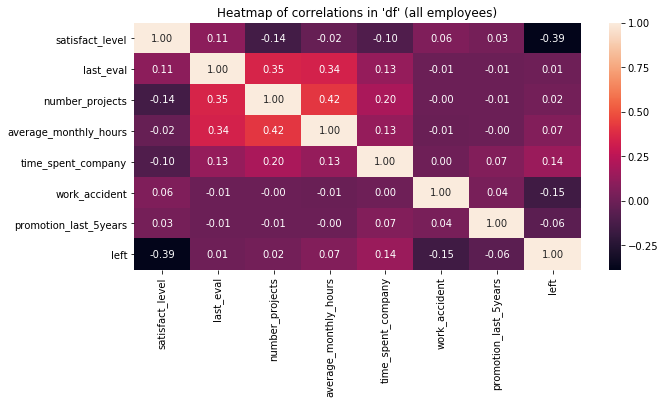

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
plt.subplot(2,1,1)
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.title("Heatmap of correlations in 'df' (all employees)");

In [14]:
df_leavers = df.loc[df['left']==1]

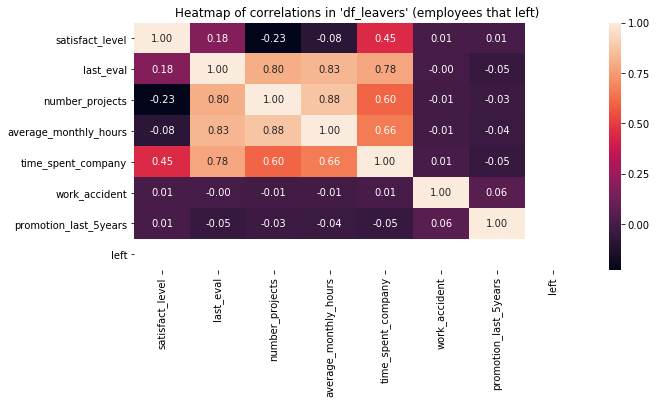

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
plt.subplot(2,1,1)
sns.heatmap(df_leavers.corr(), annot=True, fmt='.2f')
plt.title("Heatmap of correlations in 'df_leavers' (employees that left)");

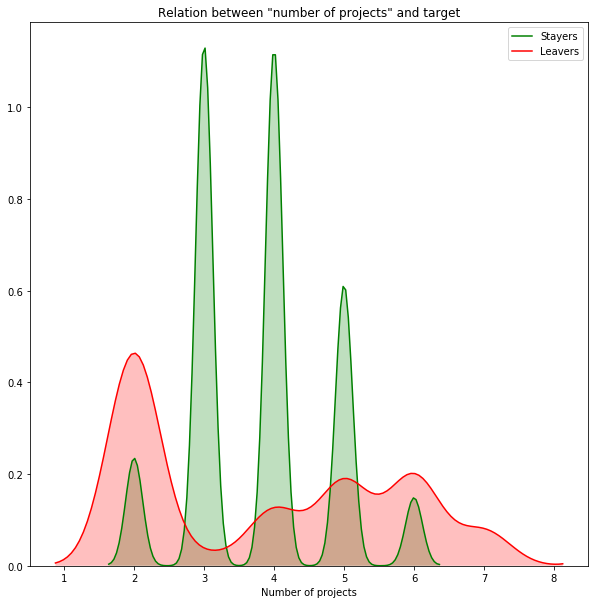

In [16]:
# Investigating further the relation of "number_projects" with target
fig = plt.figure(figsize=(10,10))
plot = sns.kdeplot(df.loc[(df['left']==0), 'number_projects'], color='g', shade=True, label='Stayers')
plot = sns.kdeplot(df.loc[(df['left']==1), 'number_projects'], color='r', shade=True, label='Leavers')
plt.title('Relation between "number of projects" and target')
plt.xlabel('Number of projects');

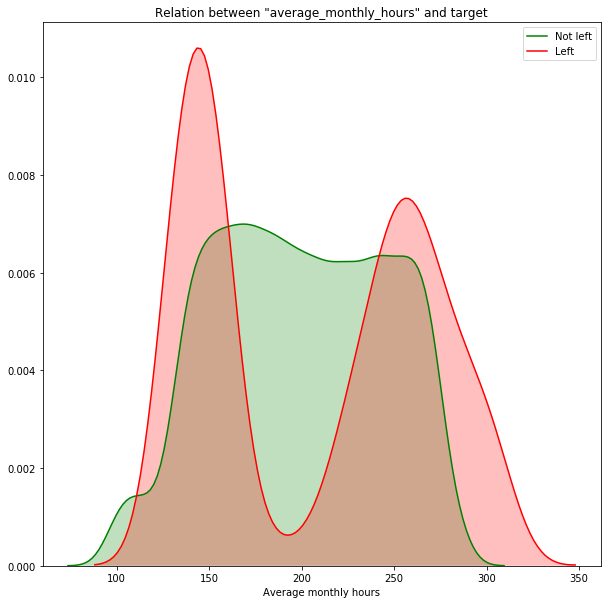

In [17]:
# Investigating further the relation of "average_monthly_hours" with target
fig = plt.figure(figsize=(10,10))
plot = sns.kdeplot(df.loc[(df['left']==0), 'average_monthly_hours'], color='g', shade=True, label='Not left')
plot = sns.kdeplot(df.loc[(df['left']==1), 'average_monthly_hours'], color='r', shade=True, label='Left')
plt.title('Relation between "average_monthly_hours" and target')
plt.xlabel('Average monthly hours');

Text(0.5,1,'Relation between "time_spent_company" and target')

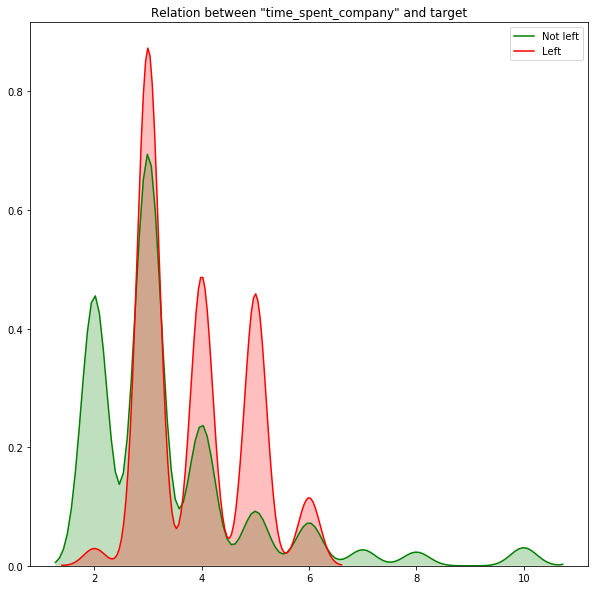

In [18]:
# Investigating further the relation of "time_spent_company" with target
fig = plt.figure(figsize=(10,10))
plot = sns.kdeplot(df.loc[(df['left']==0), 'time_spent_company'], color='g', shade=True, label='Not left')
plot = sns.kdeplot(df.loc[(df['left']==1), 'time_spent_company'], color='r', shade=True, label='Left')
plt.title('Relation between "time_spent_company" and target')

Text(0.5,1,'Relation between "last_eval" and target')

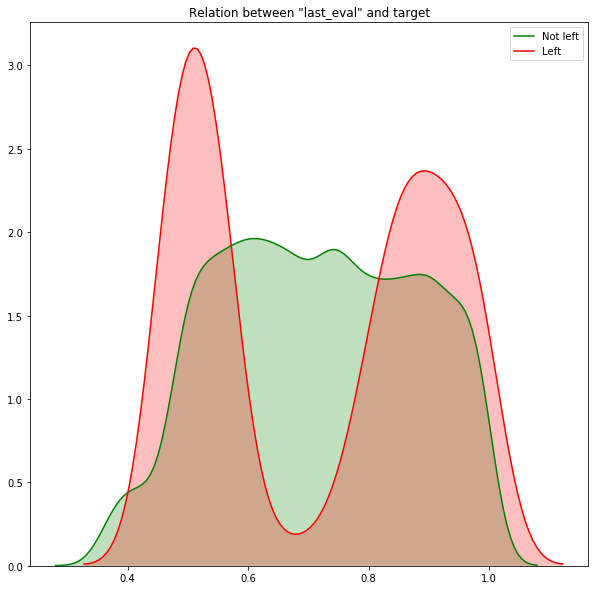

In [19]:
# Investigating further the relation of "last_eval" with target
fig = plt.figure(figsize=(10,10))
plot = sns.kdeplot(df.loc[(df['left']==0), 'last_eval'], color='g', shade=True, label='Not left')
plot = sns.kdeplot(df.loc[(df['left']==1), 'last_eval'], color='r', shade=True, label='Left')
plt.title('Relation between "last_eval" and target')

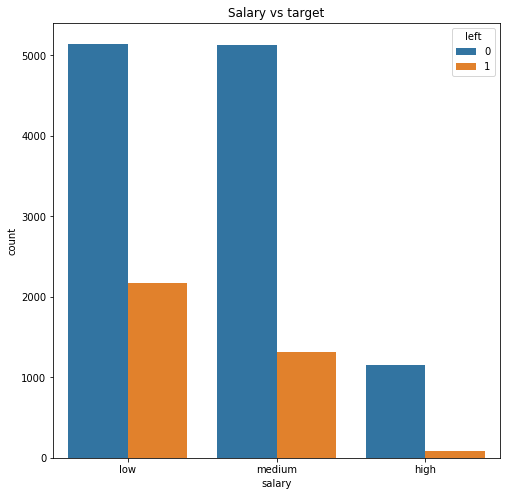

In [20]:
# Investigating further on distribution of "salary" with target
fig = plt.figure(figsize=(8,8))
sns.countplot(x='salary', hue='left', data=df)
plt.title("Salary vs target");

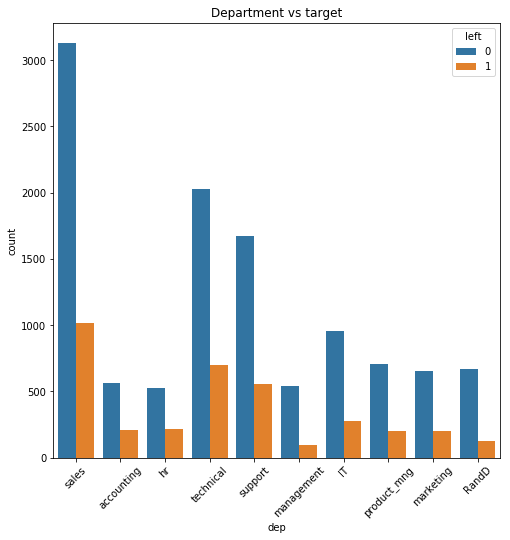

In [21]:
# Investigating further on distribution of "dep" with target
fig = plt.figure(figsize=(8,8))
sns.countplot(x='dep', hue='left', data=df)
plt.xticks(rotation=45)
plt.title("Department vs target");

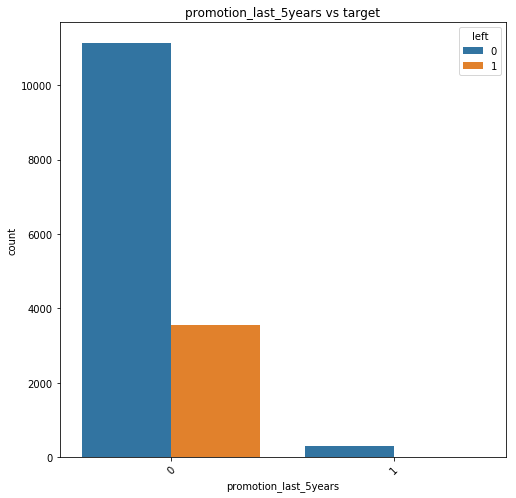

In [22]:
# Investigating further on distribution of "promotion_last_5years" with target
fig = plt.figure(figsize=(8,8))
sns.countplot(x='promotion_last_5years', hue='left', data=df)
plt.xticks(rotation=45)
plt.title("promotion_last_5years vs target");

## Machine learning

### Splitting data set to train and test set

In [25]:
target = df['left']
features = df.drop('left', axis=1)

In [26]:
# Converting categorical variables into dummy/indicator variables
features = pd.get_dummies(features)

In [28]:
rs=RobustScaler()
features=rs.fit_transform(features)

In [30]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    random_state=42,
                                                    test_size = 0.2)
                                                    
# Showing results of split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 11999 samples.
Testing set has 3000 samples.


In [31]:
y_test.value_counts()

0    2294
1     706
Name: left, dtype: int64

### Over-sampling the data, using SMOTE:

In [35]:
smpl=SMOTE(random_state=42, ratio=1.0)
X_train_smpl, y_train_smpl = smpl.fit_sample(X_train, y_train)
print(X_train_smpl.shape[0])

18268


### Fit and train models

In [36]:
# Logistic Regression
log_reg=LogisticRegression()
log_reg.fit(X_train_smpl, y_train_smpl)
print("Accuracy: {}".format(accuracy_score(y_test, log_reg.predict(X_test))))
print("Precision: {}".format(precision_score(y_test, log_reg.predict(X_test))))
print("Recall: {}".format(recall_score(y_test, log_reg.predict(X_test))))

Accuracy: 0.7653333333333333
Precision: 0.5008833922261484
Recall: 0.8031161473087819


In [37]:
# Decision Tree
dt=DecisionTreeClassifier(min_samples_split=10)
dt.fit(X_train_smpl, y_train_smpl)
print("Accuracy: {}".format(accuracy_score(y_test, dt.predict(X_test))))
print("Precision: {}".format(precision_score(y_test, dt.predict(X_test))))
print("Recall: {}".format(recall_score(y_test, dt.predict(X_test))))

Accuracy: 0.97
Precision: 0.9277777777777778
Recall: 0.9461756373937678


In [38]:
# Random Forest Classifier
rf=RandomForestClassifier()
rf.fit(X_train_smpl, y_train_smpl)
print("Accuracy: {}".format(accuracy_score(y_test, rf.predict(X_test))))
print("Precision: {}".format(precision_score(y_test, rf.predict(X_test))))
print("Recall: {}".format(recall_score(y_test, rf.predict(X_test))))

Accuracy: 0.984
Precision: 0.9781976744186046
Recall: 0.953257790368272


In [39]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv=train_test_split(features, target, test_size=0.2)

In [40]:
# Logistic Regression k-fold Cross Validation
cv_log_reg=LogisticRegression()
score_log_reg=cross_val_score(cv_log_reg, X_train_cv, y_train_cv, cv=5)
print("Accuracy: {} with (+/- {})".format(score_log_reg.mean(), score_log_reg.std() *2))

Accuracy: 0.7888992833881858 with (+/- 0.008583530278015073)


In [41]:
# Decision Tree Classifier k-fold Cross Validation
cv_dt=DecisionTreeClassifier()
score_dt=cross_val_score(cv_dt, X_train_cv, y_train_cv, cv=5)
print("Accuracy: {} with (+/- {})".format(score_dt.mean(), score_dt.std() *2))

Accuracy: 0.973997497250723 with (+/- 0.004855953245330261)


In [42]:
# Random Forest Classifier k-fold Cross Validation
cv_rf=RandomForestClassifier()
score_rf=cross_val_score(cv_rf, X_train_cv, y_train_cv, cv=5)
print("Accuracy: {} with (+/- {})".format(score_rf.mean(), score_rf.std() *2))

Accuracy: 0.984915102502622 with (+/- 0.004135704291919148)


In [43]:
# Logistic Regression k-fold Cross Validation for complete features
cv_log_reg=LogisticRegression()
score_cv_log_reg=cross_val_score(cv_log_reg, features, target, cv=5)
print("Accuracy: {} with (+/- {})".format(score_cv_log_reg.mean(), score_log_reg.std() *2))

Accuracy: 0.7694433166196277 with (+/- 0.008583530278015073)


In [44]:
# Decision Tree Classifier k-fold Cross Validation for complete features
cv_dt=DecisionTreeClassifier()
score_cv_dt=cross_val_score(cv_dt, features, target, cv=5)
print("Accuracy: {} with (+/- {})".format(score_cv_dt.mean(), score_log_reg.std() *2))

Accuracy: 0.9760660655184518 with (+/- 0.008583530278015073)


In [45]:
# Random Forest Classifier k-fold Cross Validation for complete features
cv_rf=DecisionTreeClassifier()
score_cv_rf_pr=cross_val_score(cv_rf, features, target, cv=5, scoring='precision_weighted')
print("Precision: {} with (+/- {})".format(score_cv_rf_pr.mean(), score_cv_rf_pr.std() *2))
score_cv_rf_rc=cross_val_score(cv_rf, features, target, cv=5, scoring='recall_weighted')
print("Recall: {} with (+/- {})".format(score_cv_rf_rc.mean(), score_cv_rf_rc.std() *2))
score_cv_rf=cross_val_score(cv_rf, features, target, cv=5)
print("Accuracy: {} with (+/- {})".format(score_cv_rf.mean(), score_cv_rf.std() *2))

Precision: 0.9767133140345547 with (+/- 0.019338462810930882)
Recall: 0.9761323098961826 with (+/- 0.017412883207551338)
Accuracy: 0.9751989765184048 with (+/- 0.01712380461624293)


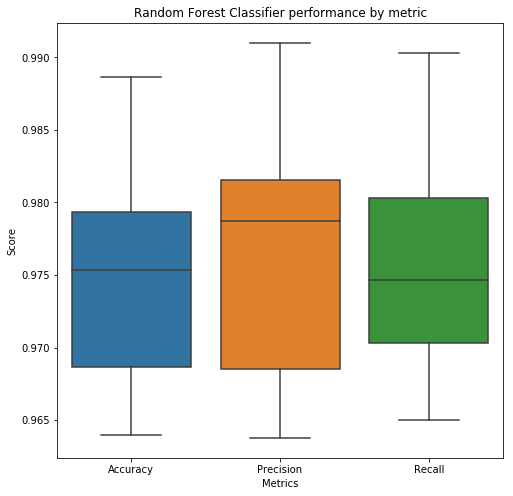

In [49]:
# Plotting the results by metric for Random Forest Classifier
score=[]
score.append(score_cv_rf)
score.append(score_cv_rf_pr)
score.append(score_cv_rf_rc)
value=[]
value.append('Accuracy')
value.append('Precision')
value.append('Recall')
plt.figure(figsize=(8,8))
plt.title("Random Forest Classifier performance by metric")
plt.xlabel("Metrics")
plt.ylabel("Score")
sns.boxplot(y=score, x=value);